In [5]:
# Import Packages
import pandas as pd
import numpy as np 
import os 
import glob
import math
from collections import OrderedDict
from datetime import timedelta
from Backtester_v19 import Backtest

# Import date and time zone libraries
import datetime
import pytz

# Import visualization
import matplotlib.pyplot as plt

# This ensures our graphs will be shown properly in the notebook
%matplotlib inline

In [6]:
class strategy_trading(Backtest):


    def __init__(self, symbol, start_year, start_month, start_day, 
                 end_year, end_month, end_day, 
                 initial_capital, max_buy, max_sell, leverage, ftc,
                 root_path, folder_name, file_name,
                 stoplosspts):
        """
        This function is executed before the backtest starts and is where we set all the variables
        """
        self.symbol = symbol
        self.start_date = datetime.datetime(start_year, start_month, start_day)
        self.end_date = datetime.datetime(end_year, end_month, end_day)
        self.initial_capital = initial_capital
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.leverage = leverage
        self.ftc = ftc # Per trade
        self.root_path = root_path
        self.folder_name = folder_name
        self.file_name = file_name
        # ---------------------------------------------------
        if not os.path.exists(self.folder_name):
            os.mkdir(self.folder_name)

        self.longShort = 0
        self.stopLossProfit = 0
        self.stopLossProfit_ID = 0
        
        self.order_dict = OrderedDict()
        self.position = 0
        self.cash = self.initial_capital
        self.holding = 0
        self.total = 0
        
        # Stop loss or profit
        self.Bar = 0
        self.stopLoss = 0
        self.stopProfit = 0
        self.stopTimeBar = 0
        
        # ------------------------------
        # Strategy parameters
        self.MA = list()
        self.stoplosspts = stoplosspts
        
        
    def Event_Processing_Engine(self, price_information):
        """
        This function is executed on every row of data
        """
        Datetime = price_information['Datetime']
        Date = price_information['Date']
        Open = price_information['Open']
        High = price_information['High']
        Low = price_information['Low']
        Close = price_information['Close']   
        
        date = pd.to_datetime(Date, format= '%Y-%m-%d %H:%M:%s').strftime('%Y-%m-%d')
        
        # Create the MA
        self.MA.append(Open)
        if len(self.MA) > 20:
            self.MA.pop(0)
            
        # Long/ Short signals
        if len(self.MA) >= 20:
            #print('Datetime: %s | Open: %s | MA: %s'%(Datetime, Open, np.mean(self.MA)))
            if Open > np.mean(self.MA): # and (nearrest_bear>self.numbers):
                self.longShort = 1
            if Open < np.mean(self.MA): # and (nearrest_bull>self.numbers):
                self.longShort = -1

        # Stop loss and Stop profit
        if self.position > 0:
            for order in self.order_dict: 
                pnl = Open - self.order_dict[order]['ExecutionPrice']
                if abs(pnl) > self.stoplosspts:
                    self.stopLossProfit = -1
                    self.stopLossProfit_ID = order
        elif self.position < 0:
            for order in self.order_dict:
                pnl = (self.order_dict[order]['ExecutionPrice'] - Open)     
                if abs(pnl) > self.stoplosspts:
                    self.stopLossProfit = 1
                    self.stopLossProfit_ID = order

        # Any long/Short trade or Any stoploss/ stopprofit trade
        if (self.longShort!=0) or (self.stopLossProfit!=0):
            return True
        return False
 
    
    def get_data(self):
        """Can be extend to handle tick or 5-min bar data on diff. symbol """
        HSI_Data = os.path.join(os.getcwd(), 'HSI_Index_2015_202003_1m.txt')
        # Read
        df_HSI = pd.read_csv(HSI_Data, sep='\t')
        df_HSI['Datetime'] = pd.to_datetime(df_HSI['Datetime'])

        HSI = df_HSI[(df_HSI.Datetime >= self.start_date) & (df_HSI.Datetime <= self.end_date)]
        HSI = HSI.reset_index(drop=True)
        return HSI 

    
    def handle_data(self):
             
        # Call back test class
        backtest = Backtest(self.symbol, self.initial_capital, self.start_date, self.end_date, 
                            self.leverage, self.root_path, self.file_name, 
                            max_buy=self.max_buy, max_sell=self.max_sell, ftc=self.ftc)
        backtest.create_log() # create_log

        # Request historical data
        df_data = self.get_data()
        df_data['Date'] = pd.to_datetime(df_data.Datetime, format= '%Y-%m-%d %H:%M:%s').dt.strftime('%Y-%m-%d')
        df_data['Date'] = pd.to_datetime(df_data['Date'])

        print(df_data)
        # --------------------------
        # Process the data beforing going to for loop

        for i in range(len(df_data)):
        #for i in range(50):
            
            self.Bar = i
            self.position = backtest.get_cur_position()
            self.order_dict = backtest.get_order_info()
            
            Datetime = df_data.loc[i, 'Datetime']
            Date = df_data.loc[i, 'Date']
            Open = df_data.loc[i, 'Open']
            High = df_data.loc[i, 'High']
            Low = df_data.loc[i, 'Low']
            Close = df_data.loc[i, 'Close']
            
            price_information={'Datetime' : Datetime,
                               'Date' : Date,
                               'Open' : Open,
                               'High' : High,
                               'Low' : Low,
                               'Close' : Close}
            
            # Check if any signals
            is_tradable = self.Event_Processing_Engine(price_information)
            if is_tradable:
                
                # Stop loss / Stop profit
                if self.stopLossProfit!=0:
                    # Place Stop Order
                    backtest.close_out(self.stopLossProfit_ID, Open)
                    self.stopLossProfit = 0
                    
                # Place Long/ Short order
                if self.longShort!=0 and backtest.Risk_Management_System(Datetime, Open):
                    order_information={'Symbol': 'MHI',
                                       'Datetime' : Datetime,
                                       'RequestPrice' : Open,
                                       'ExecutionPrice' : Open, 
                                       'Unit' : abs(self.longShort), 
                                       'Amount' : None,
                                       'StopProfit' : self.stopProfit, 
                                       'StopLoss' : self.stopLoss, 
                                       'StopTimeBar' : self.stopTimeBar}
                    # Place Order
                    if self.longShort > 0:
                        backtest.go_long(self.Bar, order_information)
                    else:
                        backtest.go_short(self.Bar, order_information)
                    self.longShort = 0
                    
            # End of day 
            #self.end_of_day(backtest, Datetime, '15:58:00', Close)

                        
        # Plot 
        backtest.Output_Pnl_Report()
        backtest.buy_sell_signals_plot(df_data.loc[:, 'Close'])   
        backtest.potfolio_pnl_plot()
        backtest.PnL_plot()


                  Datetime      Open      High       Low     Close       Date
0      2018-03-01 09:30:00  30470.99  30487.56  30453.82  30456.55 2018-03-01
1      2018-03-01 09:31:00  30457.97  30514.95  30456.50  30509.17 2018-03-01
2      2018-03-01 09:32:00  30511.16  30534.93  30498.02  30498.03 2018-03-01
3      2018-03-01 09:33:00  30496.26  30520.58  30496.26  30520.47 2018-03-01
4      2018-03-01 09:34:00  30521.22  30552.64  30521.22  30548.20 2018-03-01
...                    ...       ...       ...       ...       ...        ...
148105 2019-12-30 15:55:00  28318.37  28318.37  28295.48  28302.71 2019-12-30
148106 2019-12-30 15:56:00  28298.51  28307.78  28298.18  28300.09 2019-12-30
148107 2019-12-30 15:57:00  28296.56  28305.99  28296.56  28299.10 2019-12-30
148108 2019-12-30 15:58:00  28291.28  28307.62  28291.27  28301.07 2019-12-30
148109 2019-12-30 15:59:00  28302.36  28309.75  28295.46  28302.19 2019-12-30

[148110 rows x 6 columns]
      Month  Monthly_PnL
0   2018-03 

C:\Users\sawo\Desktop\Github\FutureQuant\Backtester_v19.py:481: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(png_name)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


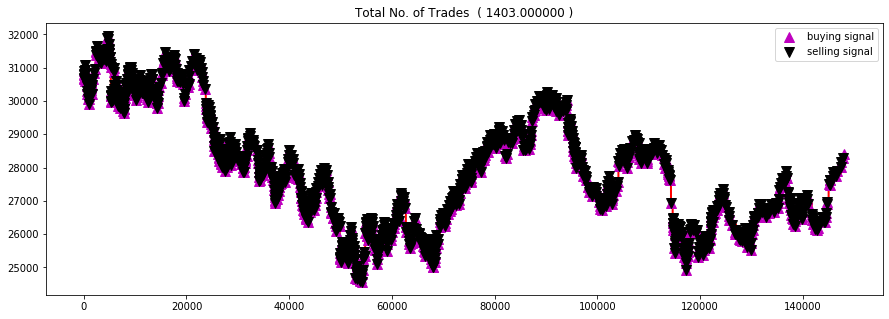

No handles with labels found to put in legend.


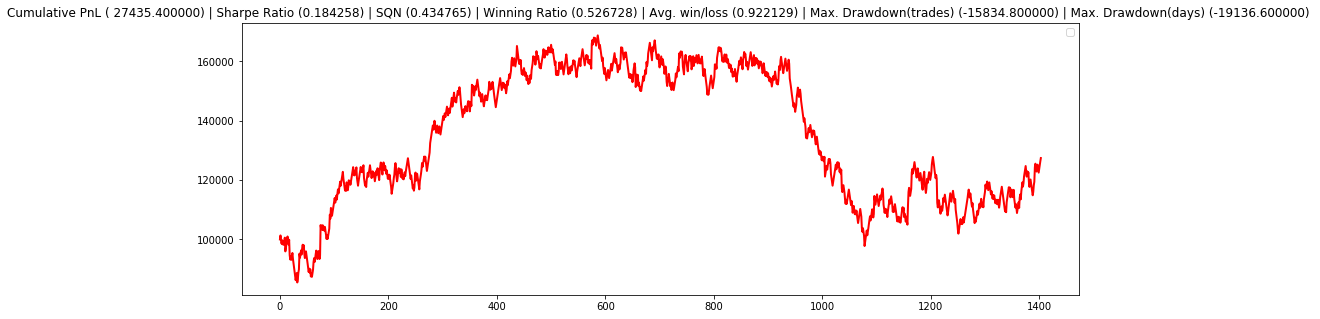

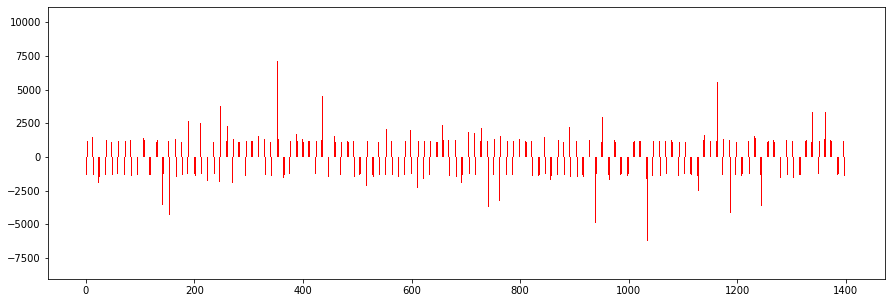

In [7]:
symbol = 'MHI'
initial_capital = 100000
max_buy = 1
max_sell = 1
leverage = 6
ftc = 80 # Per trade (2 sides)
root_path = os.path.join(os.getcwd(), 'Output')
stoplosspts = 120
folder_name = os.path.join(root_path, 'test_MA')
file_name = os.path.join(folder_name, 'BT')

strategy = strategy_trading(symbol, 2018, 3, 1, 2019, 12, 31, 
                            initial_capital, max_buy, max_sell, leverage, ftc,
                            root_path, folder_name, file_name,
                            stoplosspts)
strategy.handle_data()

'C:\\Users\\sawo\\Desktop\\Github\\FutureQuant'